In [57]:
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
nclasses=len(class_names)
dataname="trg-gray"

# --- training params
batch_size=256
patch_size=64 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up
#validation_phases= [] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up    

In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet
from torchsummary import summary

from albumentations import *
from albumentations.pytorch import ToTensor

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

from tqdm.autonotebook import tqdm


import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [25]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
gpuid=0
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11018MB, multi_processor_count=68)


In [27]:
class SmallNetwork(nn.Module):
    def __init__(self):
        super(SmallNetwork,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, padding = 1),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 6, kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(6),
            nn.Conv2d(6,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8,8,stride=2,kernel_size=3),
            nn.ReLU(True),
            nn.BatchNorm2d(8)
        )


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        

        self.final= nn.Sequential(
            nn.Linear(8, 16), #--- add dropout
            nn.ReLU(True),
            nn.BatchNorm1d(16),
            nn.Linear(16, 16),
            nn.ReLU(True),
            nn.Linear(16, nclasses),
        )
                          

        
    def forward(self,x):
        x = self.encoder(x)
        #x = self.decoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x , 1)
        x = self.final(x)
        return x

In [28]:
device = torch.device('cuda')
model = SmallNetwork().to(device)

summary(model, input_size=(1, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 64, 64]              60
              ReLU-2            [-1, 6, 64, 64]               0
       BatchNorm2d-3            [-1, 6, 64, 64]              12
            Conv2d-4            [-1, 6, 62, 62]             330
              ReLU-5            [-1, 6, 62, 62]               0
       BatchNorm2d-6            [-1, 6, 62, 62]              12
            Conv2d-7            [-1, 8, 30, 30]             440
              ReLU-8            [-1, 8, 30, 30]               0
       BatchNorm2d-9            [-1, 8, 30, 30]              16
           Conv2d-10            [-1, 8, 14, 14]             584
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13              [-1, 8, 6, 6]             584
             ReLU-14              [-1, 

In [29]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:]
            label = self.labels[index]
        
        
        img_new = img
        if self.img_transform:
            img_new = self.img_transform(image=img)['image']
        

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [30]:
img_transform={}
#img_transform["train"] = Compose([
#       VerticalFlip(p=.5),
#       HorizontalFlip(p=.5),
#       GaussNoise(),
#       GaussianBlur(),
#       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
#       Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
#       #ElasticTransform(always_apply=True, approximate=True, alpha=150, sigma=8,alpha_affine=50),
#       #RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
#       ToTensor()
#    ])


img_transform['train'] = Compose([
        #RandomScale(scale_limit=0.1,p=.9),
        #PadIfNeeded(min_height=patch_size,min_width=patch_size),        
        VerticalFlip(p=.5),
        HorizontalFlip(p=.5),
        #Blur(p=.5),
        #Downscale(p=.25, scale_min=0.64, scale_max=0.99),
        GaussNoise(p=.5, var_limit=(10.0, 50.0)),
        GridDistortion(p=.5, num_steps=5, distort_limit=(-0.3, 0.3),
                      border_mode=cv2.BORDER_REFLECT),
        #ISONoise(p=.5, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
        RandomBrightness(p=.5, limit=(-0.2, 0.2)),
        #RandomContrast(p=.5, limit=(-0.2, 0.2)),
        #RandomGamma(p=.5, gamma_limit=(80, 120), eps=1e-07),
        MultiplicativeNoise(p=.5, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
        #HueSaturationValue(hue_shift_limit=20,sat_shift_limit=10,val_shift_limit=10,p=.9),
        Rotate(p=1, border_mode=cv2.BORDER_REFLECT),
        RandomCrop(patch_size,patch_size),
        ToTensor()
    ])


img_transform["val"] = Compose([
       ToTensor()
    ])



dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform[phase])
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")


train dataset size:	12800
val dataset size:	1280


5


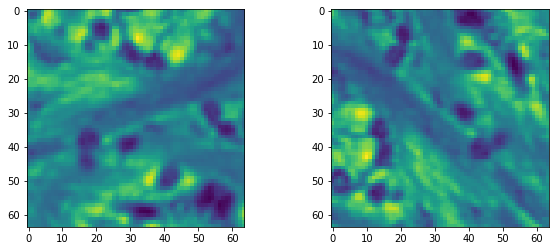

In [31]:
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][10]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [59]:
optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2) 

In [60]:
class_weight= dataset["train"].classsizes
class_weight =torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 


tensor([0.8828, 0.7734, 0.9062, 0.9531, 0.7734, 0.9062, 0.8828, 0.9219],
       device='cuda:0')


In [63]:
device = torch.device('cuda')
checkpoint = torch.load("trg-gray_smallnet_best_model.pth", map_location = device)

In [64]:
model = SmallNetwork().to(device)
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

In [65]:
#best_loss_on_test = 0.93
best_loss_on_test =checkpoint['best_loss_on_test']['val']
best_loss_on_test

0.72999036

In [66]:
#def trainnetwork():
writer=SummaryWriter() #open the tensorboard visualiser
#best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
    cmatrix = {key: np.zeros((nclasses,nclasses)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, label, img_orig) in tqdm(enumerate(dataLoader[phase]),total=len(dataLoader[phase])): #for each of the batches
            X = torch.unsqueeze(X, 1).to(device)  # [Nbatch, 3, H, W]
            label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...nclasses)

            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass]
                loss = criterion(prediction, label)


                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

                writer.add_scalar(f'{phase}/batch_loss', loss.detach().cpu().numpy(), ii+batch_size*epoch)
                
                

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses): #essentially write out confusion matrix
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'num_classes': nclasses}


        torch.save(state, f"{dataname}_smallnet_best_model.pth")
    else:
        print("")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide



0m 16s (- 26m 42s) ([1/100] 1%), train loss: 0.7905 test loss: 0.7402



0m 32s (- 26m 19s) ([2/100] 2%), train loss: 0.7933 test loss: 0.7395



0m 48s (- 26m 0s) ([3/100] 3%), train loss: 0.7949 test loss: 0.7478



1m 4s (- 25m 43s) ([4/100] 4%), train loss: 0.7898 test loss: 0.7404



1m 20s (- 25m 28s) ([5/100] 5%), train loss: 0.7927 test loss: 0.7366



1m 36s (- 25m 12s) ([6/100] 6%), train loss: 0.7880 test loss: 0.7397



1m 52s (- 24m 56s) ([7/100] 7%), train loss: 0.7911 test loss: 0.7444



2m 8s (- 24m 40s) ([8/100] 8%), train loss: 0.7938 test loss: 0.7340



2m 24s (- 24m 23s) ([9/100] 9%), train loss: 0.7893 test loss: 0.7419



2m 40s (- 24m 7s) ([10/100] 10%), train loss: 0.7947 test loss: 0.7388



2m 56s (- 23m 51s) ([11/100] 11%), train loss: 0.7888 test loss: 0.7379



3m 13s (- 23m 35s) ([12/100] 12%), train loss: 0.8002 test loss: 0.7390



3m 29s (- 23m 19s) ([13/100] 13%), train loss: 0.7955 test loss: 0.7455



3m 45s (- 23m 3s) ([14/100] 14%), train loss: 0.7953 test loss: 0.7413



4m 1s (- 22m 46s) ([15/100] 15%), train loss: 0.7869 test loss: 0.7348



4m 17s (- 22m 30s) ([16/100] 16%), train loss: 0.7967 test loss: 0.7388



4m 33s (- 22m 15s) ([17/100] 17%), train loss: 0.7997 test loss: 0.7371



4m 49s (- 21m 59s) ([18/100] 18%), train loss: 0.7946 test loss: 0.7380



5m 5s (- 21m 43s) ([19/100] 19%), train loss: 0.7886 test loss: 0.7409



5m 21s (- 21m 26s) ([20/100] 20%), train loss: 0.7944 test loss: 0.7404



5m 37s (- 21m 10s) ([21/100] 21%), train loss: 0.7952 test loss: 0.7379



5m 54s (- 20m 55s) ([22/100] 22%), train loss: 0.7951 test loss: 0.7354



6m 10s (- 20m 38s) ([23/100] 23%), train loss: 0.7941 test loss: 0.7313



6m 26s (- 20m 22s) ([24/100] 24%), train loss: 0.7963 test loss: 0.7401



6m 42s (- 20m 6s) ([25/100] 25%), train loss: 0.7916 test loss: 0.7449



6m 58s (- 19m 50s) ([26/100] 26%), train loss: 0.7916 test loss: 0.7351



7m 14s (- 19m 34s) ([27/100] 27%), train loss: 0.7909 test loss: 0.7393



7m 30s (- 19m 17s) ([28/100] 28%), train loss: 0.7886 test loss: 0.7400



7m 46s (- 19m 2s) ([29/100] 28%), train loss: 0.7962 test loss: 0.7406



8m 2s (- 18m 46s) ([30/100] 30%), train loss: 0.7935 test loss: 0.7383



8m 18s (- 18m 30s) ([31/100] 31%), train loss: 0.7889 test loss: 0.7368



8m 34s (- 18m 14s) ([32/100] 32%), train loss: 0.7924 test loss: 0.7350



8m 51s (- 17m 58s) ([33/100] 33%), train loss: 0.7960 test loss: 0.7372



9m 7s (- 17m 42s) ([34/100] 34%), train loss: 0.7846 test loss: 0.7371



9m 23s (- 17m 26s) ([35/100] 35%), train loss: 0.7891 test loss: 0.7334



9m 39s (- 17m 10s) ([36/100] 36%), train loss: 0.7939 test loss: 0.7446



9m 55s (- 16m 54s) ([37/100] 37%), train loss: 0.7834 test loss: 0.7398



10m 12s (- 16m 38s) ([38/100] 38%), train loss: 0.7898 test loss: 0.7377



10m 28s (- 16m 22s) ([39/100] 39%), train loss: 0.7970 test loss: 0.7439



10m 44s (- 16m 6s) ([40/100] 40%), train loss: 0.7949 test loss: 0.7399



11m 0s (- 15m 50s) ([41/100] 41%), train loss: 0.7933 test loss: 0.7396



11m 16s (- 15m 34s) ([42/100] 42%), train loss: 0.7866 test loss: 0.7411



11m 32s (- 15m 18s) ([43/100] 43%), train loss: 0.7892 test loss: 0.7404



11m 48s (- 15m 1s) ([44/100] 44%), train loss: 0.7872 test loss: 0.7364



12m 4s (- 14m 45s) ([45/100] 45%), train loss: 0.7964 test loss: 0.7417



12m 20s (- 14m 29s) ([46/100] 46%), train loss: 0.7927 test loss: 0.7392



12m 53s (- 13m 57s) ([48/100] 48%), train loss: 0.7898 test loss: 0.7372



13m 9s (- 13m 41s) ([49/100] 49%), train loss: 0.7905 test loss: 0.7395



13m 25s (- 13m 25s) ([50/100] 50%), train loss: 0.7947 test loss: 0.7402



13m 41s (- 13m 9s) ([51/100] 51%), train loss: 0.7832 test loss: 0.7379



13m 57s (- 12m 53s) ([52/100] 52%), train loss: 0.7914 test loss: 0.7338



14m 13s (- 12m 36s) ([53/100] 53%), train loss: 0.7914 test loss: 0.7446



14m 29s (- 12m 20s) ([54/100] 54%), train loss: 0.7929 test loss: 0.7391



14m 45s (- 12m 4s) ([55/100] 55%), train loss: 0.7914 test loss: 0.7366



15m 1s (- 11m 48s) ([56/100] 56%), train loss: 0.7854 test loss: 0.7431



15m 17s (- 11m 32s) ([57/100] 56%), train loss: 0.7978 test loss: 0.7362



15m 33s (- 11m 15s) ([58/100] 57%), train loss: 0.7914 test loss: 0.7460



15m 49s (- 10m 59s) ([59/100] 59%), train loss: 0.7927 test loss: 0.7444



16m 5s (- 10m 43s) ([60/100] 60%), train loss: 0.7935 test loss: 0.7389



16m 21s (- 10m 27s) ([61/100] 61%), train loss: 0.7934 test loss: 0.7349



16m 37s (- 10m 11s) ([62/100] 62%), train loss: 0.7954 test loss: 0.7416



16m 53s (- 9m 54s) ([63/100] 63%), train loss: 0.7933 test loss: 0.7403



17m 9s (- 9m 38s) ([64/100] 64%), train loss: 0.7930 test loss: 0.7394



17m 24s (- 9m 22s) ([65/100] 65%), train loss: 0.7901 test loss: 0.7405



17m 40s (- 9m 6s) ([66/100] 66%), train loss: 0.7943 test loss: 0.7430



17m 56s (- 8m 50s) ([67/100] 67%), train loss: 0.7917 test loss: 0.7386



18m 12s (- 8m 34s) ([68/100] 68%), train loss: 0.7930 test loss: 0.7384



18m 28s (- 8m 18s) ([69/100] 69%), train loss: 0.7921 test loss: 0.7355



18m 44s (- 8m 1s) ([70/100] 70%), train loss: 0.7925 test loss: 0.7407


KeyboardInterrupt: 

In [ ]:
X.shape

In [62]:
!tensorboard --logdir runs 

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.0.1 at http://localhost:6006/ (Press CTRL+C to quit)
W0317 12:48:51.960940 139619327952640 core_plugin.py:191] Unable to get first event timestamp for run Mar17_11-52-26_opagpu1: No event timestamp could be found
W0317 12:49:21.944766 139618690352896 core_plugin.py:191] Unable to get first event timestamp for run Mar17_11-52-26_opagpu1: No event timestamp could be found
W0317 12:49:51.952861 139619210503936 core_plugin.py:191] Unable to get first event timestamp for run Mar17_11-52-26_opagpu1: No event timestamp could be found
W0317 12:50:21.956906 139618698745600 core_plugin.py:191] Unable to get first event timestamp for run Mar17_11-52-26_opagpu1: No event timestamp could be found
W0317 12:50:51.966761 139619210503936 core_plugin.py:191] Unable to get first event timestamp for run Mar17_11-52-26_opagpu1: No event timestamp could be found
^C
